In [2]:
#import dependencies
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import contractions
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchinfo import summary

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hardik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Hardik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hardik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hardik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Pre-Processing

In [3]:
#load train and test dataset
train_ds = pd.read_csv('train.csv')
test_ds = pd.read_csv('test.csv')

In [3]:
train_ds.head()

,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [4]:
#one record is mistakenly recorded as the column indexes

n_record = list(train_ds.columns) #store column indexes as a record
train_ds.rename(columns = {n_record[0] : 'polarity', n_record[1] : 'title' , n_record[2] : 'review'}, inplace = True) #rename columns
n_record[0] = int(n_record[0]) #convert the polarity entry to int
train_ds.loc[len(train_ds)] = n_record #insert new record

In [5]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   title     object
 2   review    object
dtypes: int64(1), object(2)
memory usage: 109.9+ MB


In [6]:
#check for null records
train_ds.isnull().sum()

polarity      0
title       207
review        0
dtype: int64

In [7]:
#fill null records with empty strings
train_ds['title'].fillna('', inplace = True)

C:\Users\Hardik\AppData\Local\Temp\ipykernel_18552\2774230899.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_ds['title'].fillna('', inplace = True)


In [8]:
#combine title and review columns
train_ds['review'] = train_ds['title'] + '. ' + train_ds['review']
train_ds = train_ds.drop('title', axis = 1)

In [23]:
#convert polarity from 1&2 to 0&1
train_ds['polarity'] = train_ds['polarity'] - 1

In [24]:
train_ds.head()

,polarity,review
0,1,The best soundtrack ever to anything.. I'm rea...
1,1,Amazing!. This soundtrack is my favorite music...
2,1,Excellent Soundtrack. I truly like this soundt...
3,1,"Remember, Pull Your Jaw Off The Floor After He..."
4,1,an absolute masterpiece. I am quite sure any o...


In [11]:
#repeating same process on test set
n_record = list(test_ds.columns) 
test_ds.rename(columns = {n_record[0] : 'polarity', n_record[1] : 'title' , n_record[2] : 'review'}, inplace = True) 
n_record[0] = int(n_record[0])
test_ds.loc[len(test_ds)] = n_record 
test_ds['title'].fillna('', inplace = True)
test_ds['review'] = test_ds['title'] + '. ' + test_ds['review']
test_ds = test_ds.drop('title', axis = 1)
test_ds['polarity'] = test_ds['polarity'] - 1

C:\Users\Hardik\AppData\Local\Temp\ipykernel_18552\3673307785.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_ds['title'].fillna('', inplace = True)


In [26]:
test_ds.head()

,polarity,review
0,1,One of the best game music soundtracks - for a...
1,0,Batteries died within a year .... I bought thi...
2,1,"works fine, but Maha Energy is better. Check o..."
3,1,Great for the non-audiophile. Reviewed quite a...
4,0,DVD Player crapped out after one year. I also ...


In [32]:
#helper function to preprocess text
def preprocess(text):
    
    #expand contractions
    text = contractions.fix(text)
    #replace \n with space
    text = text.replace('\\n', ' ')
    #remove html tags
    text = re.sub('<[^>]*>', '', text)
    #remove extra whitespaces
    text = text.strip()
    #remove non-alphabetic characters and lowercase the text
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    #tokenize test
    tokens = word_tokenize(text)
    #remove stopwords
    s_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in s_words]
    #lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #join preprocessed tokens
    final_text = ' '.join(tokens)

    return final_text

In [39]:
#preprocess review column of both train and test datasets
train_ds['processed_review'] = train_ds['review'].apply(preprocess)
test_ds['processed_review'] = test_ds['review'].apply(preprocess)
train_ds.drop('review', axis = 1, inplace = True)
train_ds.head()

,polarity,processed_review
0,1,best soundtrack ever anything reading lot revi...
1,1,amazing soundtrack favorite music time hand in...
2,1,excellent soundtrack truly like soundtrack enj...
3,1,remember pull jaw floor hearing played game kn...
4,1,absolute masterpiece quite sure actually takin...


In [10]:
#check for null reviews
[train_ds.isna().sum(), test_ds.isna().sum()]

[polarity             0
 processed_review    12
 dtype: int64,
 polarity            0
 review              0
 processed_review    1
 dtype: int64]

In [11]:
#drop null records as their count is very less
train_ds = train_ds.dropna(how='any',axis=0) 
test_ds = test_ds.dropna(how='any',axis=0) 

In [12]:
#split into features and labels
reviews_train = train_ds['processed_review']
y_train = train_ds['polarity'].to_numpy()
reviews_test = test_ds['processed_review']
org_review_test = test_ds['review']
y_test = test_ds['polarity'].to_numpy()

In [13]:
#check distribution of polarity classes
np.bincount(y_train)*100.0/len(y_train)

array([50.00008333, 49.99991667])

In [14]:
np.bincount(y_test)*100.0/len(y_test)

array([50.000125, 49.999875])

In [15]:
#counting sequence lengths and storing 95th percentile
length_train = [len(sentence.split()) for sentence in reviews_train]
length_test = [len(sentence.split()) for sentence in reviews_test]
max_l_train = np.percentile(length_train, 95)
max_l_test = np.percentile(length_test, 95)

In [16]:
#helper function to truncate strings
def truncate(data, max_length):
    new_data = []
    for sentence in data:
        n_tokens = sentence.split()[:max_length]
        new_data.append(' '.join(n_tokens))
        
    return new_data

In [17]:
#truncate the reviews
reviews_train = truncate(reviews_train, int(max_l_train))
reviews_test = truncate(reviews_test, int(max_l_test))

In [18]:
#load pretrained model
vec_model = api.load("glove-wiki-gigaword-200")

In [20]:
#helper function to convert words into embedded tensors
def embed(sentence):
    tokens = sentence.split()
    embedding = []
    for token in tokens:
        if token in vec_model:
            embedding.append(vec_model[token])
        else:
            embedding.append(np.zeros(200))
            
    return torch.Tensor(np.array(embedding))

#helper function to pad and collate tensors
def pad_collate(batch):
    xx, yy = zip(*batch)
    yy = torch.stack(list(yy), dim = 0).reshape([len(xx), 1])
    x_lens = [len(x) for x in xx]
    xx_padded = pad_sequence(xx, batch_first = True)
    return xx_padded, yy, x_lens

In [21]:
#create custom datasets and dataloader
class ReviewData_Train(Dataset):
    def __init__(self):
        self.X = reviews_train
        self.Y = torch.Tensor(y_train)
    def __getitem__(self, index):
        X_embedded = embed(self.X[index])
        return X_embedded, self.Y[index]
    def __len__(self):
        return len(self.Y)

class ReviewData_Test(Dataset):
    def __init__(self):
        self.X = reviews_test
        self.Y = torch.Tensor(y_test)
    def __getitem__(self, index):
        X_embedded = embed(self.X[index])
        return X_embedded, self.Y[index]
    def __len__(self):
        return len(self.Y)

ds_train = ReviewData_Train()
ds_test = ReviewData_Test()
dl_train = DataLoader(dataset = ds_train, batch_size = 256, shuffle = True, collate_fn = pad_collate, pin_memory = True)
dl_test = DataLoader(dataset = ds_test, batch_size = 256, shuffle = False, collate_fn = pad_collate, pin_memory = True)

In [22]:
#check for cuda
torch.cuda.is_available()

True

In [23]:
#rnn model
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(200, 32, batch_first = True)
        self.dense = nn.Linear(32, 1)
    def forward(self, input):
        output_packed, hidden = self.rnn(input)
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)
        out = output_padded[range(len(output_padded)), output_lengths - 1]
        out = self.dense(out)
        return out

#lstm model
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(200, 32, batch_first = True)
        self.dense = nn.Linear(32, 1)
    def forward(self, input):
        output_packed, hidden = self.lstm(input)
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)
        out = output_padded[range(len(output_padded)), output_lengths - 1]
        out = self.dense(out)
        return out

#loss function
loss_fn = nn.BCEWithLogitsLoss()

In [24]:
#model and optimizer
model1 = RNN().to('cuda')
optimizer = torch.optim.Adam(model1.parameters())

for epoch in range(10):
        total_loss = 0
    for xx_padded, yy, x_lens in dl_train:
        #pack batch sequences
        xx_packed = pack_padded_sequence(xx_padded, x_lens, batch_first = True, enforce_sorted = False).to('cuda')
        yy = yy.to('cuda')
        
        #forward propogtion
        output = model1(xx_packed)
        loss = loss_fn(output, yy)

        #backpropogration
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss calculation
        total_loss += loss.item()
    avg_loss = total_loss/len(dl_train)
    print(f'epoch: {epoch}, loss = {avg_loss}')

epoch: 0, loss = 0.558148615188859
epoch: 1, loss = 0.5262841594928717
epoch: 2, loss = 0.516610146416528
epoch: 3, loss = 0.5071790470008379
epoch: 4, loss = 0.49366453635203483
epoch: 5, loss = 0.4894196973186566
epoch: 6, loss = 0.488786811724942
epoch: 7, loss = 0.4817232753765462
epoch: 8, loss = 0.49712421191473616
epoch: 9, loss = 0.4710409746208698


In [26]:
#evaluate
with torch.no_grad():
    predictions = []
    for xx_padded, yy, x_lens in dl_test:
        xx_packed = pack_padded_sequence(xx_padded, x_lens, batch_first = True, enforce_sorted = False).to('cuda')
        yy = yy.to('cuda')
        output = model1(xx_packed)
        probs = torch.sigmoid(output)
        probs[probs >= 0.5] = 1
        probs[probs < 0.5] = 0
        predictions = predictions + list(probs.cpu().numpy())
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
        

              precision    recall  f1-score   support

           0       0.79      0.76      0.78    200000
           1       0.77      0.80      0.78    199999

    accuracy                           0.78    399999
   macro avg       0.78      0.78      0.78    399999
weighted avg       0.78      0.78      0.78    399999



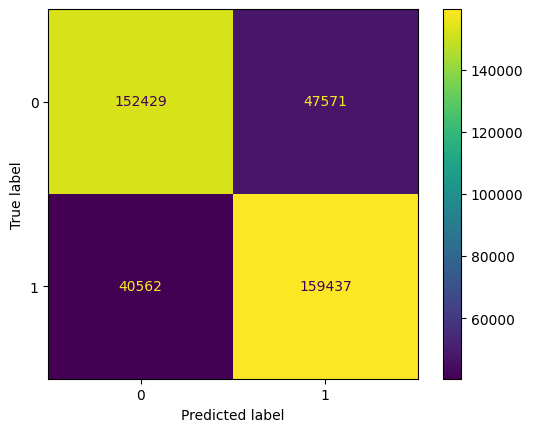

In [27]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [107]:
#analyze errors
sample = test_ds[test_ds['polarity'] != np.array(predictions).reshape(len(y_test),)].sample(5)
sample

,polarity,review,processed_review
42705,1,Fitting the Music to the Mood. Xiu Xiu are one...,fitting music mood xiu xiu one inventive imagi...
104526,0,Good looks but shabby quality. I was really ex...,good look shabby quality really excited receiv...
75219,1,Neglected masterpiece. Back when bands were so...,neglected masterpiece back band somehow able m...
363759,0,Tall Pasta Canister. Just too flimsy for my us...,tall pasta canister flimsy use heat sensitive ...
149386,1,Inspirational Christian Rock with catchy beat ...,inspirational christian rock catchy beat throu...


In [108]:
list(sample['review'])

['Fitting the Music to the Mood. Xiu Xiu are one of the most inventive and imaginative bands out there right now. Their music evokes dark imaginary in my mind when I listen to it. Personally, A Promise is my favorite album by them, but I would recommend any. If you are reading a review for Xiu Xiu then you are on the right track and you should by this album. A side note: I had the pleasure to see Xiu Xiu play last weekend in my town of Missoula, Montana.. Unfortunately, their van was broken into late in the night and their equipment was stolen. They have cancelled their tour. Hopefully, their instruments will surface. By this disc and support real musical genius.',
 'Good looks but shabby quality. I was really excited to receive this pair of gorgeous sandals, but upon a few hours of wearing them, the links broke! Needless to say, I had to return them - very reluctantly.',
 'Neglected masterpiece. Back when bands were somehow able to make live recordings full of surprises, excitement, a

In [62]:
#recalculate lengths are truncating
length_test = [len(sentence.split()) for sentence in reviews_test]

In [114]:
sample_short = test_ds[(y_test != np.array(predictions).reshape(len(y_test),)) & (np.array(length_test) < 8)].sample(5)
sample_short

,polarity,review,processed_review
17196,0,Not as I imagined!. These slipper were very bu...,imagined slipper bulky cloddy smell lavender p...
26757,1,what it says it is. basic but what i wanted wh...,say basic wanted say basic wanted nice
325161,0,NOT what you see. I ordered this product but w...,see ordered product got see picture
242719,1,smashing!. this is unwound at their best.if yo...,smashing unwound best album sheer perfection s...
240026,0,Not what I expected. They need a better produc...,expected need better product description video...


In [115]:
list(sample_short['review'])

['Not as I imagined!. These slipper were very bulky & cloddy (?) and the smell from the lavender was not very pleasant at all.',
 'what it says it is. basic but what i wanted what more can I say they are basic but that is what I wanted.... nice',
 'NOT what you see. I ordered this product but when I got it it is not what you see in the picture !!!!!!',
 "smashing!. this is unwound at their best.if you don't have this album then you don't have sheer perfection in your stereo.",
 'Not what I expected. They need a better product description for this video. It was not what I expected.']

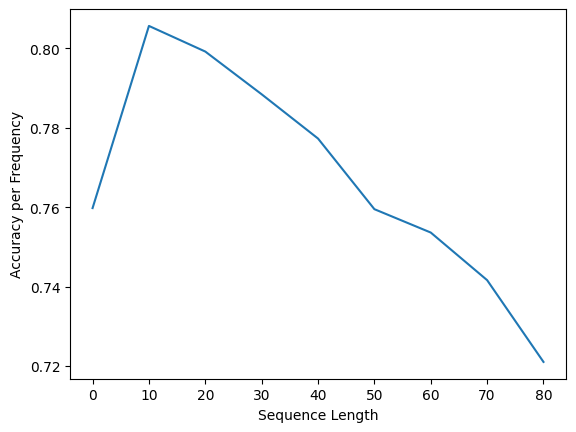

In [149]:
#calculate accuracy of model per frequency for bins of 10 sequence length
correct_lens = np.array(length_test)[y_test == np.array(predictions).reshape(len(y_test),)]
len_hist, _ = np.histogram(length_test, bins = range(0, ceil(np.max(length_test)/10.0)*10 + 1, 10))
corr_hist, _ = np.histogram(correct_lens, bins = range(0, ceil(np.max(length_test)/10.0)*10 + 1, 10))
bin_acc = corr_hist/len_hist

#plot the accuracy
plt.plot(range(0, ceil(np.max(length_test)/10.0)*10, 10), bin_acc)
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy per Frequency')
plt.show()

In [150]:
#model and optimizer
model2 = LSTM().to('cuda')
optimizer = torch.optim.Adam(model2.parameters())

for epoch in range(10):
    total_loss = 0
    for xx_padded, yy, x_lens in dl_train:
        #pack batch sequences
        xx_packed = pack_padded_sequence(xx_padded, x_lens, batch_first = True, enforce_sorted = False).to('cuda')
        yy = yy.to('cuda')
        
        #forward propogtion
        output = model2(xx_packed)
        loss = loss_fn(output, yy)

        #backpropogration
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #loss calculation
        total_loss += loss.item()
    avg_loss = total_loss/len(dl_train)
    print(f'epoch: {epoch}, loss = {avg_loss}')

epoch: 0, loss = 0.2661215097246151
epoch: 1, loss = 0.22962327116390027
epoch: 2, loss = 0.22074733857413253
epoch: 3, loss = 0.21574105527870502
epoch: 4, loss = 0.21260172210849385
epoch: 5, loss = 0.21018782163835273
epoch: 6, loss = 0.2081706487301962
epoch: 7, loss = 0.2066078569854229
epoch: 8, loss = 0.20538299637287377
epoch: 9, loss = 0.20419096145022606


In [152]:
#evaluate
with torch.no_grad():
    predictions = []
    for xx_padded, yy, x_lens in dl_test:
        xx_packed = pack_padded_sequence(xx_padded, x_lens, batch_first = True, enforce_sorted = False).to('cuda')
        yy = yy.to('cuda')
        output = model2(xx_packed)
        probs = torch.sigmoid(output)
        probs[probs >= 0.5] = 1
        probs[probs < 0.5] = 0
        predictions = predictions + list(probs.cpu().numpy())
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91    200000
           1       0.94      0.87      0.90    199999

    accuracy                           0.91    399999
   macro avg       0.91      0.91      0.91    399999
weighted avg       0.91      0.91      0.91    399999



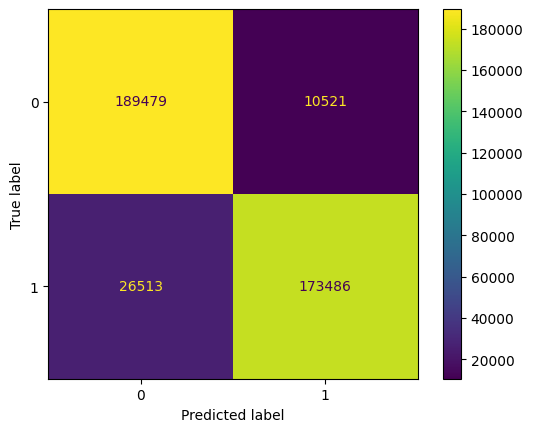

In [153]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [155]:
#analyze errors
sample = test_ds[test_ds['polarity'] != np.array(predictions).reshape(len(y_test),)].sample(5)
sample

,polarity,review,processed_review
15314,1,Does NOT have Liszt's two-piano version of pia...,liszt two piano version piano concerto amazon ...
270289,1,Not bad for a Brit. It's a sad day in the US w...,bad brit sad day u go overseas find rapper rhy...
106490,1,It Will Put A Spell On Ya.... This is the firs...,put spell ya first angelo album bought say dov...
378930,0,86 Lives and Still Sleeping in a Walk in Close...,life still sleeping walk closet book state one...
329343,0,new album not worth dancing to.. i have seen f...,new album worth dancing seen face face time co...


In [156]:
list(sample['review'])

["Does NOT have Liszt's two-piano version of piano concerto no. 1. The Amazon listing incorrectly shows that this CD contains S650, Liszt's two-piano version of piano concerto no. 1 It includes only the more common version S124.",
 "Not bad for a Brit. It's a sad day in the US when we have to go overseas to find rappers who rhyme over good beats. Not that anything on this album is mind blowing, but it's a solid effort with decent lyrics and good, soulful beats based around samples that remind you of golden age hiphop.Even though he's white, he does a convincing job rhyming about the projects. I guess in London they call them council estates. Oh, those cheeky Brits. What will they think of next?",
 'It Will Put A Spell On Ya.... This is the first D\'Angelo album I\'ve bought, and I have to say that I dove right into "Voodoo" with low expectations from the get-go. The other reviewers keep saying that D is mumbling and that the songs are too long. This is true... in addition to the fact t

In [157]:
sample_short = test_ds[(y_test != np.array(predictions).reshape(len(y_test),)) & (np.array(length_test) < 8)].sample(5)
sample_short

,polarity,review,processed_review
394679,0,.... This is not a vary good book. There are m...,vary good book informitive book one
373604,0,Debi. It works just as well as all of those di...,debi work well diet pill word work
91817,0,not happy. it's an demo and some of the show w...,happy demo show good would rate
111530,1,This book is not out of print. Call 1-800-777-...,book print call book second printing well
168895,0,Not his best. This book is not what it is hype...,best book hyped informative thought would


In [158]:
list(sample_short['review'])

['.... This is not a vary good book. There are more informitive books out there. And this is not one of them.',
 'Debi. It works just as well as all of those diet pills out there. In other words, it does not work at all.',
 "not happy. it's an demo and some of the show was off. but it's was good. but wouldn't rate it at all.",
 'This book is not out of print. Call 1-800-777-2295. The book is now in its second printing and doing well!',
 'Not his best. This book is not what it is hyped to be, Not very informative and not what I thought it would be.']

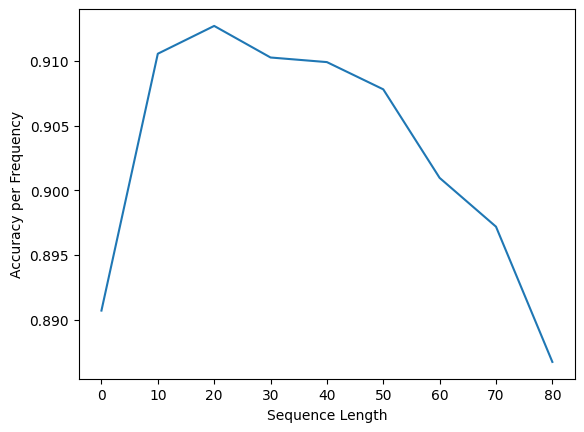

In [159]:
#calculate accuracy of model per frequency for bins of 10 sequence length
correct_lens = np.array(length_test)[y_test == np.array(predictions).reshape(len(y_test),)]
len_hist, _ = np.histogram(length_test, bins = range(0, ceil(np.max(length_test)/10.0)*10 + 1, 10))
corr_hist, _ = np.histogram(correct_lens, bins = range(0, ceil(np.max(length_test)/10.0)*10 + 1, 10))
bin_acc = corr_hist/len_hist

#plot the accuracy
plt.plot(range(0, ceil(np.max(length_test)/10.0)*10, 10), bin_acc)
plt.xlabel('Sequence Length')
plt.ylabel('Accuracy per Frequency')
plt.show()